# Loan Repayment Prediction – XGBoost with Advanced Feature Engineering & CV

This notebook builds a high-performance model to predict **loan repayment** for the 
Kaggle Playground Series S5E11 dataset. The pipeline includes:

- Exploratory Data Analysis (EDA) to understand the data
- Financial-domain feature engineering (affordability, risk, credit interactions)
- Categorical encodings:
  - Factorized numeric "cat" features
  - Strategic interaction features
  - Count encoding for all categorical-like features
  - Per-fold target encoding (leakage-free)
- External dataset augmentation (loan_dataset_20000)
- Final **XGBoost** model with **GPU** acceleration
- 8-fold **Stratified K-Fold CV** and early stopping
- Tuned hyperparameters (from separate Optuna study) for strong AUC and low overfitting

We finish by training the final model on the full data and generating `submission_tuned.csv`.


In [6]:
# Imports & Global Configuration
import os
import warnings
import logging

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import KBinsDiscretizer

import xgboost as xgb
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

logging.basicConfig(level=logging.INFO, format="%(message)s")
logger = logging.getLogger(__name__)

# Global config
CONF = {
    "seed": 42,
    "target": "loan_paid_back",
    "train_path": "/kaggle/input/playground-series-s5e11/train.csv",
    "test_path": "/kaggle/input/playground-series-s5e11/test.csv",
    "orig_path": "/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv",
    "sample_submission_path": "/kaggle/input/playground-series-s5e11/sample_submission.csv",
    # Final model CV
    "n_folds": 8,
    "num_boost_round_final": 12000,
    "early_stopping_rounds_final": 350,
}

TARGET = CONF["target"]

# Detect GPU for safe tree_method
USE_GPU = True
try:
    import torch
    USE_GPU = torch.cuda.is_available()
except Exception:
    USE_GPU = False

TREE_METHOD = "gpu_hist" if USE_GPU else "hist"
PREDICTOR = "gpu_predictor" if USE_GPU else "auto"

np.random.seed(CONF["seed"])


In [7]:
# 1. Load Data
def load_data():
    train = pd.read_csv(CONF["train_path"])
    test = pd.read_csv(CONF["test_path"])
    orig = pd.read_csv(CONF["orig_path"])

    logger.info(f"Train: {train.shape}")
    logger.info(f"Test : {test.shape}")
    logger.info(f"Orig : {orig.shape}")
    return train, test, orig

train, test, orig = load_data()

# Keep sizes for later split after feature engineering
n_train = len(train)
n_test = len(test)
n_orig = len(orig)

# Dummy target in test to allow some combined operations (will not be used for training)
test[TARGET] = -1


Train: (593994, 13)
Test : (254569, 12)
Orig : (20000, 22)


## 2. Exploratory Data Analysis (EDA)

We start with some basic EDA on the training data:

- Overall shape and column types  
- Target distribution  
- Summary statistics for key numeric features  
- Missing values  
- A few relationships between important features and the target  


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB
None

Describe (numeric):


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,296996.500000,48212.202976,0.120696,680.916009,15020.297629,12.356345,0.798820
std,171471.442235,26711.942078,0.068573,55.424956,6926.530568,2.008959,0.400883
min,0.000000,6002.430000,0.011000,395.000000,500.090000,3.200000,0.000000
25%,148498.250000,27934.400000,0.072000,646.000000,10279.620000,10.990000,1.000000
50%,296996.500000,46557.680000,0.096000,682.000000,15000.220000,12.370000,1.000000
75%,445494.750000,60981.320000,0.156000,719.000000,18858.580000,13.680000,1.000000
max,593993.000000,393381.740000,0.627000,849.000000,48959.950000,20.990000,1.000000



Target distribution:
loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64


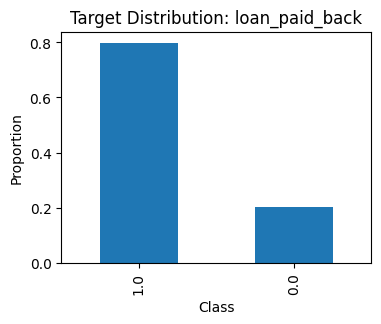

In [8]:
# 2. EDA – Basic Overview
display(train.head())
print("\nInfo:")
print(train.info())

print("\nDescribe (numeric):")
display(train.describe())

# Target distribution
print("\nTarget distribution:")
print(train[TARGET].value_counts(normalize=True))

plt.figure(figsize=(4,3))
train[TARGET].value_counts(normalize=True).plot(kind="bar")
plt.title("Target Distribution: loan_paid_back")
plt.xlabel("Class")
plt.ylabel("Proportion")
plt.show()


Missing value ratio per column:


,missing_ratio
id,0.0
annual_income,0.0
debt_to_income_ratio,0.0
credit_score,0.0
loan_amount,0.0
interest_rate,0.0
gender,0.0
marital_status,0.0
education_level,0.0
employment_status,0.0


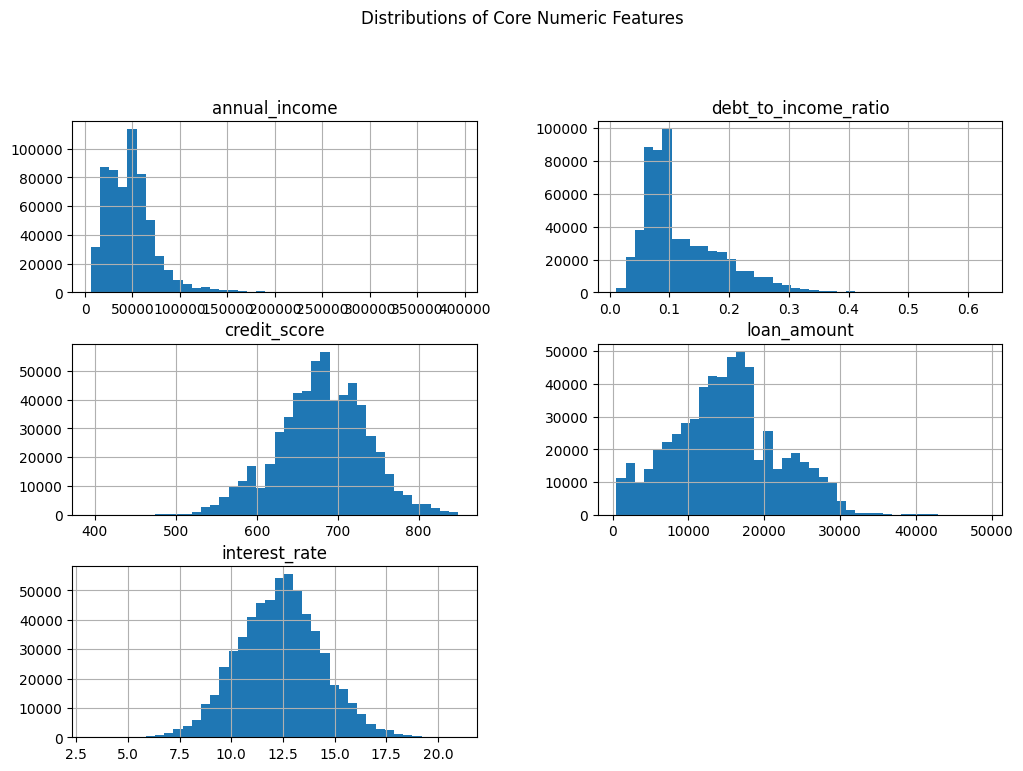

In [9]:
# Missing values per column
missing = train.isna().mean().sort_values(ascending=False)
print("Missing value ratio per column:")
display(missing.to_frame("missing_ratio").head(20))

# Histograms for key numeric features
num_cols = ["annual_income", "debt_to_income_ratio", "credit_score", "loan_amount", "interest_rate"]
train[num_cols].hist(figsize=(12, 8), bins=40)
plt.suptitle("Distributions of Core Numeric Features", y=1.02)
plt.show()


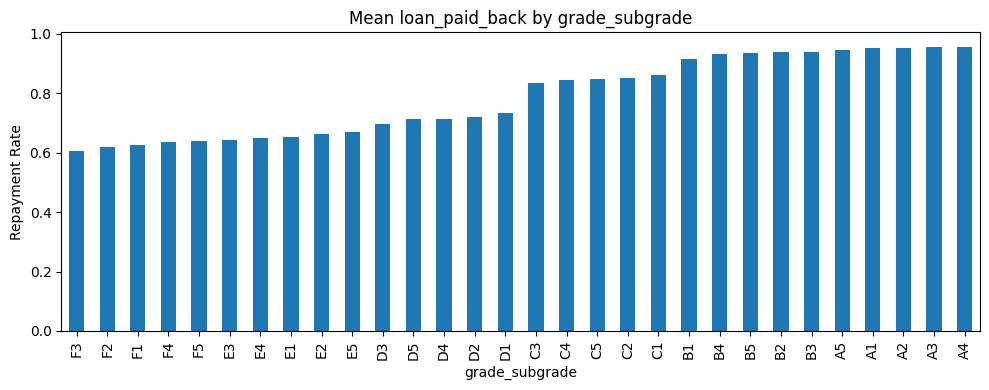

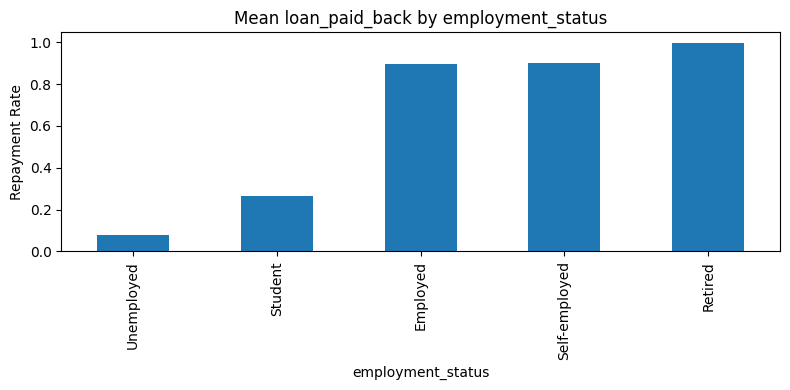

In [10]:
# Relationship between grade_subgrade and target
plt.figure(figsize=(10,4))
grade_target = (
    train.groupby("grade_subgrade")[TARGET]
    .mean()
    .sort_values()
)
grade_target.plot(kind="bar")
plt.title("Mean loan_paid_back by grade_subgrade")
plt.ylabel("Repayment Rate")
plt.tight_layout()
plt.show()

# Relationship between employment_status and target
plt.figure(figsize=(8,4))
emp_target = (
    train.groupby("employment_status")[TARGET]
    .mean()
    .sort_values()
)
emp_target.plot(kind="bar")
plt.title("Mean loan_paid_back by employment_status")
plt.ylabel("Repayment Rate")
plt.tight_layout()
plt.show()


## 3. Feature Engineering

We now construct a rich set of features that encode:

- **Affordability and risk** (income vs loan, debt burden, payment ratios)
- **Credit behaviour** (credit score interactions with debt and interest)
- **Transformed variables** (log of annual income / loan amount)
- **Grade information** (grade letter, grade number, rank)
- **Categorical encodings**:
  - Numeric "cat" features via `factorize()`
  - Strategic pairwise interactions between key categories
  - Count encoding for all categorical-like features
  - Per-fold **target encoding** for selected categorical features

We also integrate an external dataset (`loan_dataset_20000`) as additional training data (orig augmentation).


In [11]:
# 3. Advanced financial feature engineering
logger.info("\n[STEP 1] Creating Enhanced Financial Features...")

def create_advanced_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Core affordability
    df["income_loan_ratio"] = df["annual_income"] / (df["loan_amount"] + 1)
    df["loan_to_income"] = df["loan_amount"] / (df["annual_income"] + 1)

    # Debt metrics
    df["total_debt"] = df["debt_to_income_ratio"] * df["annual_income"]
    df["available_income"] = df["annual_income"] * (1 - df["debt_to_income_ratio"])
    df["debt_burden"] = df["debt_to_income_ratio"] * df["loan_amount"]

    # Payment analysis
    df["monthly_payment"] = df["loan_amount"] * df["interest_rate"] / 1200
    df["payment_to_income"] = df["monthly_payment"] / (df["annual_income"] / 12 + 1)
    df["affordability"] = df["available_income"] / (df["loan_amount"] + 1)

    # Risk scoring
    df["default_risk"] = (
        df["debt_to_income_ratio"] * 0.40
        + (850 - df["credit_score"]) / 850 * 0.35
        + df["interest_rate"] / 100 * 0.25
    )

    # Credit analysis
    df["credit_utilization"] = df["credit_score"] * (1 - df["debt_to_income_ratio"])
    df["credit_interest_product"] = df["credit_score"] * df["interest_rate"] / 100

    # Log transforms
    for col in ["annual_income", "loan_amount"]:
        df[f"{col}_log"] = np.log1p(df[col])

    # Grade parsing
    df["grade_subgrade"] = df["grade_subgrade"].astype(str)
    df["grade_letter"] = df["grade_subgrade"].str[0]
    df["grade_number"] = (
        df["grade_subgrade"].str[1:]
        .str.extract(r"(\d+)", expand=False)
        .fillna("0")
        .astype(int)
    )
    grade_map = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7}
    df["grade_rank"] = df["grade_letter"].map(grade_map).fillna(4).astype(int)

    return df

# Base categorical & numerical feature sets
CATS_BASE = [
    "gender",
    "marital_status",
    "education_level",
    "employment_status",
    "loan_purpose",
    "grade_subgrade",
]

NUMS_BASE = [
    "annual_income",
    "debt_to_income_ratio",
    "credit_score",
    "loan_amount",
    "interest_rate",
]

NEW_FEATURES = [
    "income_loan_ratio",
    "loan_to_income",
    "total_debt",
    "available_income",
    "debt_burden",
    "monthly_payment",
    "payment_to_income",
    "affordability",
    "default_risk",
    "credit_utilization",
    "credit_interest_product",
    "annual_income_log",
    "loan_amount_log",
    "grade_letter",
    "grade_number",
    "grade_rank",
]

logger.info(f"Created {len(NEW_FEATURES)} new features")

# Build combined frame for FE
combine = pd.concat([train, test, orig], axis=0, ignore_index=True)
combine_fe = create_advanced_features(combine)



[STEP 1] Creating Enhanced Financial Features...
Created 16 new features


In [12]:
# Target encoding helper (train/valid/test)
def kfold_target_encode_train_valid_test(
    Xy_train: pd.DataFrame,
    X_valid: pd.DataFrame,
    X_test: pd.DataFrame,
    col: str,
    target_col: str,
    n_splits: int = 10,
    seed: int = 42,
):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    tr_encoded = pd.Series(index=Xy_train.index, dtype="float32")
    y = Xy_train[target_col].values

    for tr_idx, val_idx in kf.split(Xy_train, y):
        tr_slice = Xy_train.iloc[tr_idx]
        means = tr_slice.groupby(col)[target_col].mean()
        tr_encoded.iloc[val_idx] = Xy_train.iloc[val_idx][col].map(means).astype(
            "float32"
        )

    global_means = Xy_train.groupby(col)[target_col].mean()
    val_encoded = X_valid[col].map(global_means).astype("float32")
    test_encoded = X_test[col].map(global_means).astype("float32")

    global_avg = Xy_train[target_col].mean().astype("float32")
    tr_encoded.fillna(global_avg, inplace=True)
    val_encoded.fillna(global_avg, inplace=True)
    test_encoded.fillna(global_avg, inplace=True)

    return tr_encoded.values, val_encoded.values, test_encoded.values


In [13]:
# 4. Dataset preparation (factorize + interactions + CE)
def prepare_datasets(
    combine_fe: pd.DataFrame,
    n_train: int,
    n_test: int,
    n_orig: int,
    use_quantile_bins: bool = False,
):
    combine = combine_fe.copy()

    # Categorical + numeric sets
    CATS = CATS_BASE.copy()
    NUMS = NUMS_BASE + [f for f in NEW_FEATURES if f not in ["grade_letter"]]
    CATS.append("grade_letter")

    # Numeric "cat" features
    CATS_NUM = []
    if use_quantile_bins:
        logger.info("Using quantile bins for numeric _cat features...")
        for c in NUMS:
            n = f"{c}_cat"
            est = KBinsDiscretizer(
                n_bins=50,
                encode="ordinal",
                strategy="quantile",
            )
            combine[n] = est.fit_transform(combine[[c]]).astype("int32")
            CATS_NUM.append(n)
    else:
        logger.info("Using factorize() for numeric _cat features...")
        for c in NUMS:
            n = f"{c}_cat"
            combine[n], _ = combine[c].factorize()
            combine[n] = combine[n].astype("int32")
            CATS_NUM.append(n)

    logger.info(f"Created {len(CATS_NUM)} numeric _cat features")

    # Strategic 2-way interactions
    important_pairs = [
        ("employment_status", "grade_subgrade"),
        ("employment_status", "education_level"),
        ("employment_status", "loan_purpose"),
        ("grade_subgrade", "loan_purpose"),
        ("grade_subgrade", "education_level"),
        ("marital_status", "employment_status"),
    ]

    for num_cat in ["credit_score_cat", "debt_to_income_ratio_cat", "interest_rate_cat"]:
        for cat in ["employment_status", "grade_subgrade"]:
            important_pairs.append((num_cat, cat))

    CATS_INTER = []
    for c1, c2 in important_pairs:
        name = f"{c1}_{c2}"
        if c1 in combine.columns and c2 in combine.columns:
            combine[name] = combine[c1].astype(str) + "_" + combine[c2].astype(str)
            CATS_INTER.append(name)

    logger.info(f"Created {len(CATS_INTER)} strategic interactions")

    # Count encoding for all categorical-ish features
    CE = []
    ALL_CATS = CATS + CATS_NUM + CATS_INTER

    logger.info(f"\nCreating count encoding for {len(ALL_CATS)} categorical features...")
    for c in tqdm(ALL_CATS, desc="Count encoding"):
        tmp = combine.groupby(c)[TARGET].count()
        tmp.name = f"CE_{c}"
        CE.append(f"CE_{c}")
        combine = combine.merge(tmp, on=c, how="left")

    logger.info(f"Created {len(CE)} count encodings")

    # Split back
    train_full = combine.iloc[:n_train].copy()
    test_full = combine.iloc[n_train : n_train + n_test].copy()
    orig_full = combine.iloc[-n_orig:].copy()

    logger.info(
        f"\nTrain_full: {train_full.shape}, Test_full: {test_full.shape}, Orig_full: {orig_full.shape}"
    )

    FEATURES = NUMS + CATS + CATS_NUM + CATS_INTER + CE
    logger.info(f"Total FEATURES: {len(FEATURES)}")

    return train_full, test_full, orig_full, FEATURES, CATS, CATS_NUM, CATS_INTER

train_full, test_full, orig_full, FEATURES, CATS, CATS_NUM, CATS_INTER = prepare_datasets(
    combine_fe,
    n_train=n_train,
    n_test=n_test,
    n_orig=n_orig,
    use_quantile_bins=False,
)

y_all = train_full[TARGET].astype(int).values
pos = (y_all == 1).sum()
neg = (y_all == 0).sum()
scale_pos_weight = neg / pos
logger.info(f"\nAuto scale_pos_weight: {scale_pos_weight:.3f}")

# Features to target-encode
TARGET_ENCODE_CATS = CATS_NUM + CATS_INTER


Using factorize() for numeric _cat features...
Created 20 numeric _cat features
Created 12 strategic interactions

Creating count encoding for 39 categorical features...


Count encoding:   0%|          | 0/39 [00:00<?, ?it/s]

Created 39 count encodings

Train_full: (593994, 110), Test_full: (254569, 110), Orig_full: (20000, 110)
Total FEATURES: 98

Auto scale_pos_weight: 0.252


In [14]:
# 5. Generic CV runner with TE and optional orig augmentation
def run_cv_with_params(
    params: dict,
    n_folds: int,
    num_boost_round: int,
    early_stopping_rounds: int,
    use_orig_aug: bool,
    random_state: int = 42,
    return_test: bool = False,
):
    """
    Runs StratifiedKFold CV with:
      - optional orig augmentation
      - per-fold target encoding on TARGET_ENCODE_CATS
    Returns OOF AUC, fold scores, and optionally blended test predictions.
    """
    logger.info(
        f"\nRunning CV with {n_folds} folds, use_orig_aug={use_orig_aug}, "
        f"num_boost_round={num_boost_round}, early_stopping_rounds={early_stopping_rounds}"
    )

    kf = StratifiedKFold(
        n_splits=n_folds, shuffle=True, random_state=random_state
    )

    oof_preds = np.zeros(n_train, dtype="float32")
    test_preds = np.zeros(n_test, dtype="float32") if return_test else None
    fold_scores = []
    best_iters = []

    X_orig = orig_full[FEATURES + [TARGET]].copy() if use_orig_aug else None
    X_test_base = test_full[FEATURES].copy()

    for fold, (tr_idx, val_idx) in enumerate(
        kf.split(train_full[FEATURES], y_all), 1
    ):
        logger.info(f"\n========== Fold {fold}/{n_folds} ==========")
        X_tr = train_full.iloc[tr_idx][FEATURES + [TARGET]].copy()
        X_val = train_full.iloc[val_idx][FEATURES + [TARGET]].copy()

        if use_orig_aug and X_orig is not None:
            Xy_train = pd.concat([X_tr, X_orig], axis=0, ignore_index=True)
        else:
            Xy_train = X_tr.copy()

        X_valid = X_val[FEATURES].copy()
        y_valid = X_val[TARGET].astype(int).values
        X_test = X_test_base.copy()

        # Target encoding on selected features
        logger.info(f"Target encoding {len(TARGET_ENCODE_CATS)} features...")
        for c in tqdm(TARGET_ENCODE_CATS, desc="Target encoding", leave=False):
            if c not in Xy_train.columns:
                continue
            tr_te, val_te, te_te = kfold_target_encode_train_valid_test(
                Xy_train[[c, TARGET]],
                X_valid[[c]],
                X_test[[c]],
                col=c,
                target_col=TARGET,
                n_splits=10,
                seed=random_state,
            )
            Xy_train[c] = tr_te
            X_valid[c] = val_te
            if return_test:
                X_test[c] = te_te

        # Cast raw categoricals
        for col in CATS:
            Xy_train[col] = Xy_train[col].astype("category")
            X_valid[col] = X_valid[col].astype("category")
            if return_test:
                X_test[col] = X_test[col].astype("category")

        dtrain = xgb.DMatrix(
            Xy_train[FEATURES],
            label=Xy_train[TARGET].astype(int).values,
            enable_categorical=True,
        )
        dvalid = xgb.DMatrix(
            X_valid[FEATURES],
            label=y_valid,
            enable_categorical=True,
        )
        dtest = (
            xgb.DMatrix(X_test[FEATURES], enable_categorical=True)
            if return_test
            else None
        )

        evals = [(dtrain, "train"), (dvalid, "valid")]
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=evals,
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False,
        )

        best_iter = (
            model.best_iteration if model.best_iteration is not None else num_boost_round
        )
        best_iters.append(best_iter)

        oof_fold = model.predict(dvalid, iteration_range=(0, best_iter + 1))
        oof_preds[val_idx] = oof_fold
        fold_auc = roc_auc_score(y_valid, oof_fold)
        fold_scores.append(fold_auc)
        logger.info(f"Fold {fold} AUC: {fold_auc:.6f}, best_iter={best_iter}")

        if return_test and dtest is not None:
            test_fold = model.predict(dtest, iteration_range=(0, best_iter + 1))
            test_preds += test_fold / n_folds

    overall_auc = roc_auc_score(y_all, oof_preds)
    logger.info("\nCV summary:")
    logger.info(f"Fold AUCs: {[f'{s:.6f}' for s in fold_scores]}")
    logger.info(f"OOF AUC : {overall_auc:.6f}")
    logger.info(f"Mean AUC: {np.mean(fold_scores):.6f}")
    logger.info(f"Std AUC : {np.std(fold_scores):.6f}")
    logger.info(f"Avg best_iter: {np.mean(best_iters):.1f}")

    if return_test:
        return overall_auc, np.array(fold_scores), test_preds, np.array(best_iters)
    else:
        return overall_auc, np.array(fold_scores)


## 6. Final XGBoost Model – Tuned Hyperparameters

We now use the **best hyperparameters** obtained from the Optuna tuning run
(optimized with 3-fold CV and the same feature pipeline):

```json
{
  "learning_rate": 0.006753042313371171,
  "max_leaves": 24,
  "min_child_weight": 11.389333443975096,
  "subsample": 0.7022354717252686,
  "colsample_bytree": 0.6567749812874956,
  "gamma": 0.011519409805970292,
  "lambda": 3.4488900751419047,
  "alpha": 2.003399843868209,
  "max_bin": 256
}


In [15]:
# 6. Final XGBoost params (from Optuna) and 8-fold CV
best_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": TREE_METHOD,
    "predictor": PREDICTOR,
    "verbosity": 0,
    "seed": CONF["seed"],
    "scale_pos_weight": scale_pos_weight,
    "learning_rate": 0.006753042313371171,
    "max_depth": 0,  # use lossguide + max_leaves
    "grow_policy": "lossguide",
    "max_leaves": 24,
    "min_child_weight": 11.389333443975096,
    "subsample": 0.7022354717252686,
    "colsample_bytree": 0.6567749812874956,
    "gamma": 0.011519409805970292,
    "lambda": 3.4488900751419047,
    "alpha": 2.003399843868209,
    "max_bin": 256,
}

logger.info("\n[STEP 3] Training final model with best params on 8-fold CV...")

final_oof_auc, final_fold_scores, final_test_preds, final_best_iters = run_cv_with_params(
    params=best_params,
    n_folds=CONF["n_folds"],
    num_boost_round=CONF["num_boost_round_final"],
    early_stopping_rounds=CONF["early_stopping_rounds_final"],
    use_orig_aug=True,
    random_state=CONF["seed"],
    return_test=True,
)

logger.info(f"\nFinal 8-fold OOF AUC: {final_oof_auc:.6f}")
logger.info(f"Fold AUCs: {[f'{s:.6f}' for s in final_fold_scores]}")
logger.info(f"Avg best_iter: {np.mean(final_best_iters):.1f}")



[STEP 3] Training final model with best params on 8-fold CV...

Running CV with 8 folds, use_orig_aug=True, num_boost_round=12000, early_stopping_rounds=350

========== Fold 1/8 ==========
Target encoding 32 features...


Target encoding:   0%|          | 0/32 [00:00<?, ?it/s]

Fold 1 AUC: 0.927573, best_iter=3753

========== Fold 2/8 ==========
Target encoding 32 features...


Target encoding:   0%|          | 0/32 [00:00<?, ?it/s]

Fold 2 AUC: 0.927031, best_iter=3004

========== Fold 3/8 ==========
Target encoding 32 features...


Target encoding:   0%|          | 0/32 [00:00<?, ?it/s]

Fold 3 AUC: 0.926952, best_iter=3169

========== Fold 4/8 ==========
Target encoding 32 features...


Target encoding:   0%|          | 0/32 [00:00<?, ?it/s]

Fold 4 AUC: 0.924316, best_iter=3011

========== Fold 5/8 ==========
Target encoding 32 features...


Target encoding:   0%|          | 0/32 [00:00<?, ?it/s]

Fold 5 AUC: 0.926269, best_iter=2271

========== Fold 6/8 ==========
Target encoding 32 features...


Target encoding:   0%|          | 0/32 [00:00<?, ?it/s]

Fold 6 AUC: 0.925120, best_iter=3064

========== Fold 7/8 ==========
Target encoding 32 features...


Target encoding:   0%|          | 0/32 [00:00<?, ?it/s]

Fold 7 AUC: 0.927430, best_iter=3655

========== Fold 8/8 ==========
Target encoding 32 features...


Target encoding:   0%|          | 0/32 [00:00<?, ?it/s]

Fold 8 AUC: 0.926440, best_iter=3596

CV summary:
Fold AUCs: ['0.927573', '0.927031', '0.926952', '0.924316', '0.926269', '0.925120', '0.927430', '0.926440']
OOF AUC : 0.926384
Mean AUC: 0.926392
Std AUC : 0.001069
Avg best_iter: 3190.4

Final 8-fold OOF AUC: 0.926384
Fold AUCs: ['0.927573', '0.927031', '0.926952', '0.924316', '0.926269', '0.925120', '0.927430', '0.926440']
Avg best_iter: 3190.4


In [16]:
# 7. Save Submission
logger.info("\n[STEP 4] Saving tuned submission...")

submission = pd.read_csv(CONF["sample_submission_path"])
submission[TARGET] = final_test_preds

out_path = "/kaggle/working/submission_tuned.csv"
submission.to_csv(out_path, index=False)
logger.info(f"✓ Saved {out_path}")



[STEP 4] Saving tuned submission...
✓ Saved /kaggle/working/submission_tuned.csv
